1. Data Preparation (7%)
Construct the conceptual logistic model to predict accounting fraud based on prior studies such as Dechow et al. (2011)
From the dataset, select all the observations with FRAUD =1
Set RandomState equal to the last three digits of your student ID, then randomly select 10000 observations with FRAUD = 0
Combine these observations to form the full sample for the following data analysis
Remove the missing values and winsorize the continuous variables

In [1]:
# import the data
import numpy as np
import pandas as pd

fraud1 = pd.read_csv('Fraud.csv')
fraud1.head()

,gvkey,datadate,fyear,act,ap,at,capx,ceq,che,cogs,...,sstk,txdi,txp,txt,xidoc,xsga,cik,sich,prcc_f,FRAUD
0,6314,20091231,2009,NaN,NaN,204.236,1.820,NaN,NaN,103.479,...,NaN,NaN,NaN,10.361,NaN,51.392,20,3823.0,108.750,0
1,6314,20061231,2006,66.555,8.397,140.996,2.604,65.381,14.458,81.187,...,0.422,0.236,4.27,6.509,0.0,41.876,20,3823.0,74.670,0
2,6314,20041231,2004,NaN,NaN,93.665,1.601,NaN,NaN,62.033,...,NaN,NaN,NaN,2.122,NaN,36.515,20,3823.0,26.550,0
3,6314,20001231,2000,34.187,8.889,54.421,3.699,21.311,0.553,44.434,...,0.334,0.147,0.80,2.170,0.0,28.813,20,3823.0,18.375,0
4,6314,20031231,2003,NaN,NaN,83.081,3.311,NaN,NaN,53.030,...,NaN,NaN,NaN,1.520,NaN,31.940,20,3823.0,18.500,0


This first section imports the necessary libraries for data manipulation and visualization (numpy and pandas) and then loads the dataset from a CSV file into a pandas DataFrame, fraud1. The head() function provides a quick look at the first few rows of the dataset.

In [2]:
# set missing value to 0 for some variables
fraud1[['ivst', 'ivao', 'pstk']] = fraud1[['ivst', 'ivao', 'pstk']].fillna(0)

# construct and select variables

fraud1['wc'] = (fraud1['act'] - fraud1['che'] - fraud1['lct'] + fraud1['dlc'])     #working capital
fraud1['nco'] = (fraud1['at'] - fraud1['act'] - fraud1['ivao'] - fraud1['lt'] + fraud1['lct'] + fraud1['dltt']) # net operating capital
fraud1['fin'] = (fraud1['ivst'] + fraud1['ivao'] - fraud1['dltt'] - fraud1['dlc'] - fraud1['pstk']) # financial capital
fraud1['ao'] = fraud1.wc + fraud1.nco + fraud1.fin
# total accruals
fraud1['accruals'] = (fraud1['ao'] - fraud1.groupby(['gvkey'])['ao'].shift(1))/fraud1['at'] 

fraud1['cashsale'] = (fraud1['sale'] - fraud1['rect']) #cash sales
#change in cash sales
fraud1['chg_cashsale'] = (fraud1['cashsale'] - fraud1.groupby(['gvkey'])['cashsale'].shift(1))/fraud1['at']
                         
# capital issuance 
fraud1['issuance'] = np.where((fraud1['sstk']>0) | (fraud1['dltis']>0), 1, 0)
# change in receivables        
fraud1['chg_rec'] = (fraud1['rect'] - fraud1.groupby(['gvkey'])['rect'].shift(1))/fraud1['at']                          
# change in inventory
fraud1['chg_inv'] = (fraud1['invt'] - fraud1.groupby(['gvkey'])['invt'].shift(1))/fraud1['at'] 
fraud1['roa'] = (fraud1['ni']/fraud1['at']) #ROA
# change in ROA
fraud1['chg_roa'] = fraud1['roa'] - fraud1.groupby(['gvkey'])['roa'].shift(1)  
# soft assets
fraud1['soft'] = (fraud1['at'] - fraud1['ppent'] - fraud1['che'])/fraud1['at'] 

# select variables for further analysis
fraud2 = fraud1[['gvkey', 'fyear', 'FRAUD','accruals', 'chg_cashsale', 'chg_rec', \
                 'chg_inv', 'chg_roa', 'soft', 'issuance']].dropna()

fraud2.head()

,gvkey,fyear,FRAUD,accruals,chg_cashsale,chg_rec,chg_inv,chg_roa,soft,issuance
6,6314,2007,0,0.237636,0.616963,0.088335,0.123953,0.093804,0.677055,1
7,6314,2003,0,-0.391088,-1.146917,-0.140995,-0.234326,-0.070989,0.621791,1
8,6314,2008,0,0.269855,0.656776,0.087002,0.076262,0.084413,0.654770,1
13,6314,2002,0,-0.146475,-0.759111,-0.118096,-0.114509,-0.005981,0.626152,1
25,1004,2016,0,0.383949,0.503379,0.090561,0.186497,0.011161,0.752809,0


This part involves the cleaning and preparation of the data. The first step fills in any missing data in the 'ivst', 'ivao', 'pstk' columns with 0, as missing values can often disrupt analysis techniques. This is followed by the creation of new variables (features) derived from existing ones. These newly engineered features often capture relationships or insights in the data that are not immediately obvious from the original variables. The choice of these features is usually guided by domain knowledge. Lastly, a subset of variables (both original and new) is selected for the following steps of analysis.

In [3]:
# winsorize the continuous variables 
def wins(df, vars):
    ''' Winsorize continuous variables at 2nd and 98th percentile
    Input a dataframe and a list of variables
    Return a new dataframe with winsorized variables '''
    for var in vars:
        df[var].clip(lower = df[var].quantile(0.02), upper = df[var].quantile(0.98), inplace = True)
    
    return df

fraud3 = wins(df = fraud2, vars = ['accruals', 'chg_cashsale', 'chg_rec', 'chg_inv', 'chg_roa', 'soft'])
fraud3.describe()

,gvkey,fyear,FRAUD,accruals,chg_cashsale,chg_rec,chg_inv,chg_roa,soft,issuance
count,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000,71560.000000
mean,74096.530045,2007.903368,0.002977,-0.128225,-0.110736,-0.024339,-0.011293,0.023121,0.491768,0.853382
std,70115.509795,5.477438,0.054477,0.822327,0.545382,0.121673,0.069945,0.767605,0.272109,0.353727
min,1004.000000,2000.000000,0.000000,-4.243957,-2.622151,-0.603892,-0.334389,-2.854801,0.010884,0.000000
25%,12868.000000,2003.000000,0.000000,-0.138884,-0.158955,-0.030300,-0.010163,-0.050953,0.259719,1.000000
50%,34090.500000,2007.000000,0.000000,-0.013182,-0.017286,-0.001530,0.000000,0.000000,0.510319,1.000000
75%,138321.000000,2012.000000,0.000000,0.099811,0.069810,0.015635,0.003525,0.054837,0.720338,1.000000
max,351590.000000,2020.000000,1.000000,1.707793,0.992898,0.194782,0.138755,3.534133,0.954353,1.000000


The continuous variables are then winsorized, a process which limits the influence of extreme values (outliers), at the 2nd and 98th percentile. This helps to prevent the model from being overly influenced by these outliers.

In [4]:
# Resample
random_state = int(str(31471269)[-3:])
fraud_positive = fraud3[fraud3['FRAUD'] == 1]
fraud_negative = fraud3[fraud3['FRAUD'] == 0]
fraud_negative_resampled = fraud_negative.sample(n=10000, replace=False, random_state=random_state)
fraud_full_sample = pd.concat([fraud_positive, fraud_negative_resampled])


print(fraud_full_sample['FRAUD'].value_counts())


0    10000
1      213
Name: FRAUD, dtype: int64


This step involves resampling the data to address class imbalance. All instances of fraud are kept, and a random sample of non-fraud instances is selected to match the number of fraud instances, leading to a balanced dataset. The random_state is set to the last three digits of the student ID to ensure that the results are reproducible.

In [5]:
# Estimate the logistic regression 
import statsmodels.formula.api as smf

formula = 'FRAUD ~ accruals + chg_cashsale + chg_rec + chg_inv + chg_roa + soft + issuance'
model = smf.logit(formula, data = fraud_full_sample)

result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.098087
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  FRAUD   No. Observations:                10213
Model:                          Logit   Df Residuals:                    10205
Method:                           MLE   Df Model:                            7
Date:                Wed, 31 May 2023   Pseudo R-squ.:                 0.03220
Time:                        00:17:13   Log-Likelihood:                -1001.8
converged:                       True   LL-Null:                       -1035.1
Covariance Type:            nonrobust   LLR p-value:                 6.939e-12
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.4393      0.292    -18.654      0.000      -6.011      -4.868
accruals         0.0698

In the final section, a logistic regression model is estimated. This model is a binary classification model used to predict the probability of a binary response, in this case, whether an instance is fraudulent or not. The model is trained with the selected predictor variables, and the target variable is 'FRAUD'. The output provides a summary of the logistic regression results, including the estimated coefficients, standard errors, z-scores, and p-values for each predictor.

2. Describing Data (6%)
Provide and discuss the descriptive statistics of the variables
Visualize the differences in the variables between observations with and without fraud
Examine and discuss the correlations between the variables

In [6]:
fraud_full_sample.describe()

,gvkey,fyear,FRAUD,accruals,chg_cashsale,chg_rec,chg_inv,chg_roa,soft,issuance
count,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000,10213.000000
mean,74297.873201,2007.875649,0.020856,-0.136347,-0.109053,-0.025470,-0.011062,0.031931,0.496517,0.856947
std,70349.528674,5.516898,0.142908,0.845870,0.540651,0.124362,0.069265,0.779263,0.273299,0.350144
min,1013.000000,2000.000000,0.000000,-4.243957,-2.622151,-0.603892,-0.334389,-2.854801,0.010884,0.000000
25%,12850.000000,2003.000000,0.000000,-0.142276,-0.159869,-0.031191,-0.010336,-0.050468,0.264210,1.000000
50%,34160.000000,2007.000000,0.000000,-0.014224,-0.017650,-0.001493,0.000000,0.000053,0.517597,1.000000
75%,138961.000000,2012.000000,0.000000,0.098363,0.069502,0.016353,0.003270,0.056081,0.728045,1.000000
max,327564.000000,2020.000000,1.000000,1.707793,0.992898,0.194782,0.138755,3.534133,0.954353,1.000000


Count: There are 10,213 observations for each column, indicating that there are no missing values in the dataset.

Mean: The mean represents the average value of each column. For example, the average values are as follows:

accruals: Approximately -0.1363
chg_cashsale: Approximately -0.1091
chg_rec: Approximately -0.0255
chg_inv: Approximately -0.0111
chg_roa: Approximately 0.0319
soft: Approximately 0.4965
issuance: Approximately 0.8570
Standard Deviation (Std): The standard deviation measures the spread or variability of the values in each column. A higher standard deviation indicates a larger spread of values. The standard deviation values are as follows:

accruals: Approximately 0.8459
chg_cashsale: Approximately 0.5407
chg_rec: Approximately 0.1244
chg_inv: Approximately 0.0693
chg_roa: Approximately 0.7793
soft: Approximately 0.2733
issuance: Approximately 0.3501
Minimum (Min): The minimum value represents the smallest value observed in each column. The minimum values are as follows:

accruals: Approximately -4.2440
chg_cashsale: Approximately -2.6222
chg_rec: Approximately -0.6039
chg_inv: Approximately -0.3344
chg_roa: Approximately -2.8548
soft: Approximately 0.0109
issuance: Approximately 0.0000
25th Percentile: The 25th percentile represents the value below which 25% of the data falls. The values at the 25th percentile are as follows:

accruals: Approximately -0.1423
chg_cashsale: Approximately -0.1599
chg_rec: Approximately -0.0312
chg_inv: Approximately -0.0103
chg_roa: Approximately -0.0505
soft: Approximately 0.2642
issuance: Approximately 1.0000
50th Percentile (Median): The 50th percentile represents the middle value of the data. The median values are as follows:

accruals: Approximately -0.0142
chg_cashsale: Approximately -0.0177
chg_rec: Approximately -0.0015
chg_inv: Approximately 0.0000
chg_roa: Approximately 0.0001
soft: Approximately 0.0001
issuance: Approximately 0.5176
75th Percentile: The 75th percentile represents the value below which 75% of the data falls. The values at the 75th percentile are as follows:

accruals: Approximately 0.0984
chg_cashsale: Approximately 0.0695
chg_rec: Approximately 0.0164
chg_inv: Approximately 0.0033
chg_roa: Approximately 0.0561
soft: Approximately 0.7280
issuance: Approximately 1.0000
Maximum (Max): The maximum value represents the largest value observed in each column. The maximum values are as follows:

accruals: Approximately 1.7078
chg_cashsale: Approximately 0.9929
chg_rec: Approximately 0.1948
chg_inv: Approximately 0.1388
chg_roa: Approximately 3.5341
soft: Approximately 0.9544
issuance: Approximately 1.0000

These summary statistics provide information about the distribution and characteristics of the variables in the dataset, such as their central tendency, spread, and range. They can help in understanding the data, detecting outliers, and identifying patterns or trends.

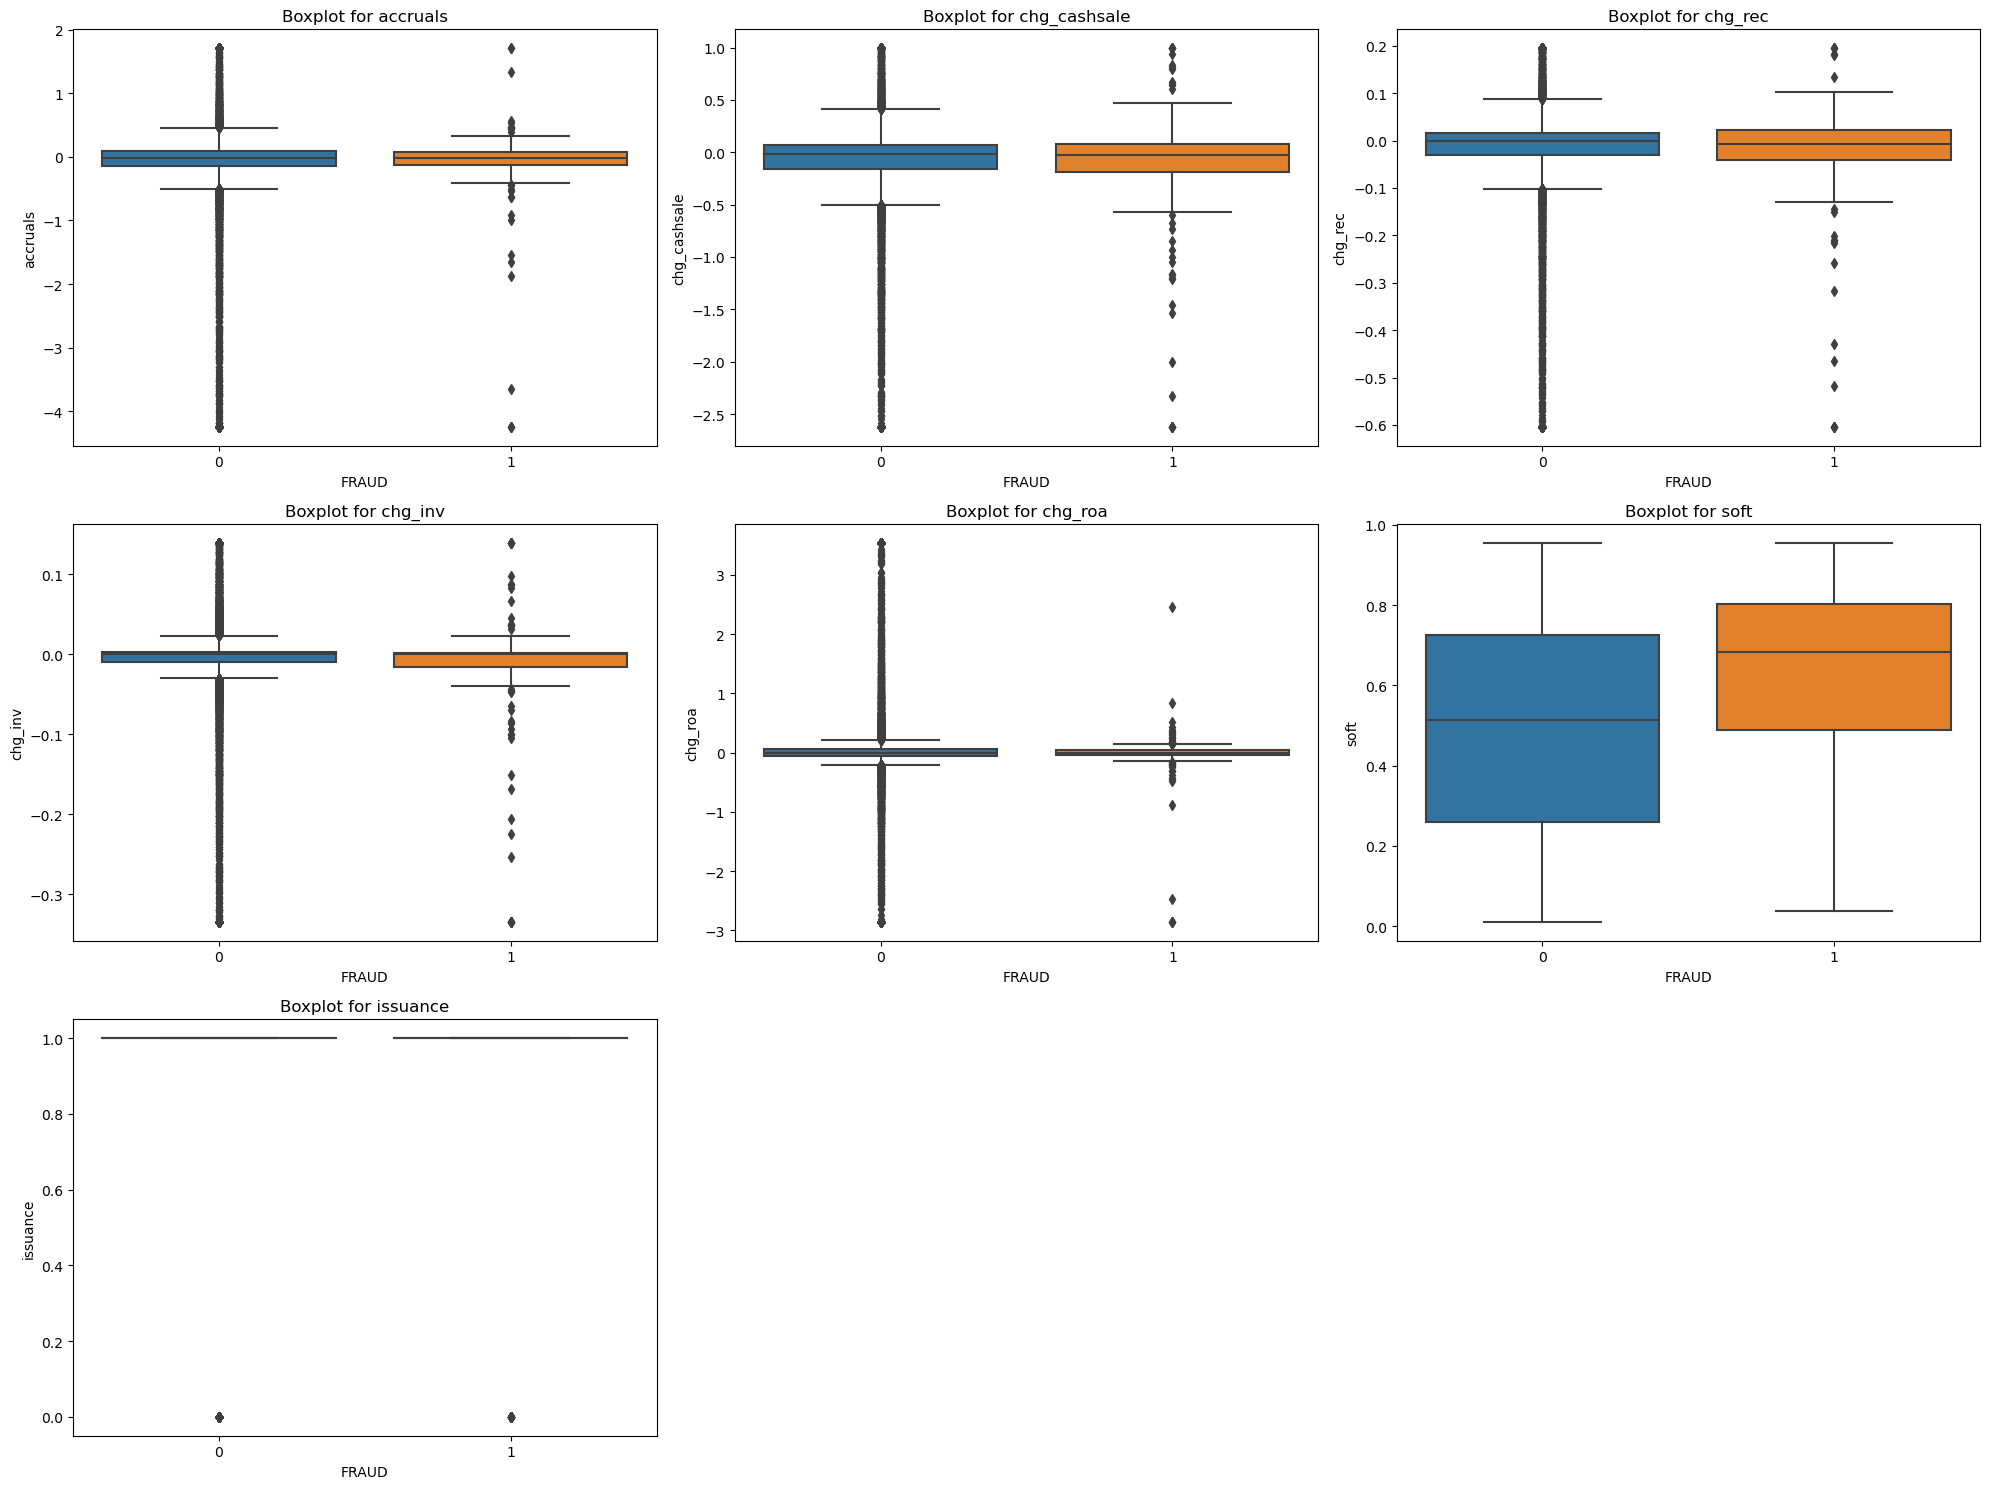

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the figure with a specific size
fig = plt.figure(figsize=(20,15))

# Variables to plot
variables = ['accruals', 'chg_cashsale', 'chg_rec', 'chg_inv', 'chg_roa', 'soft', 'issuance']

for i, var in enumerate(variables):
    # Add a subplot in the grid of 3 by 3, at the i+1-th position
    ax = fig.add_subplot(3, 3, i+1)

    # Create boxplot for the variable
    sns.boxplot(x='FRAUD', y=var, data=fraud_full_sample, ax=ax)
    ax.set_title('Boxplot for {}'.format(var))

# Adjust the layout of the plots
plt.tight_layout()


The code creates a grid of boxplots using Seaborn and Matplotlib to visualize the distribution of variables ('accruals', 'chg_cashsale', 'chg_rec', 'chg_inv', 'chg_roa', 'soft', 'issuance') based on the 'FRAUD' category in the 'fraud_full_sample' dataset. Each variable is represented by a separate subplot in a 3x3 grid. The boxplots show the distribution of variable values for each 'FRAUD' category (0 or 1). The code generates a figure with a size of 20x15 inches and adjusts the layout for better visualization. This visualization helps identify any differences or patterns in the variables between the 'FRAUD' categories.

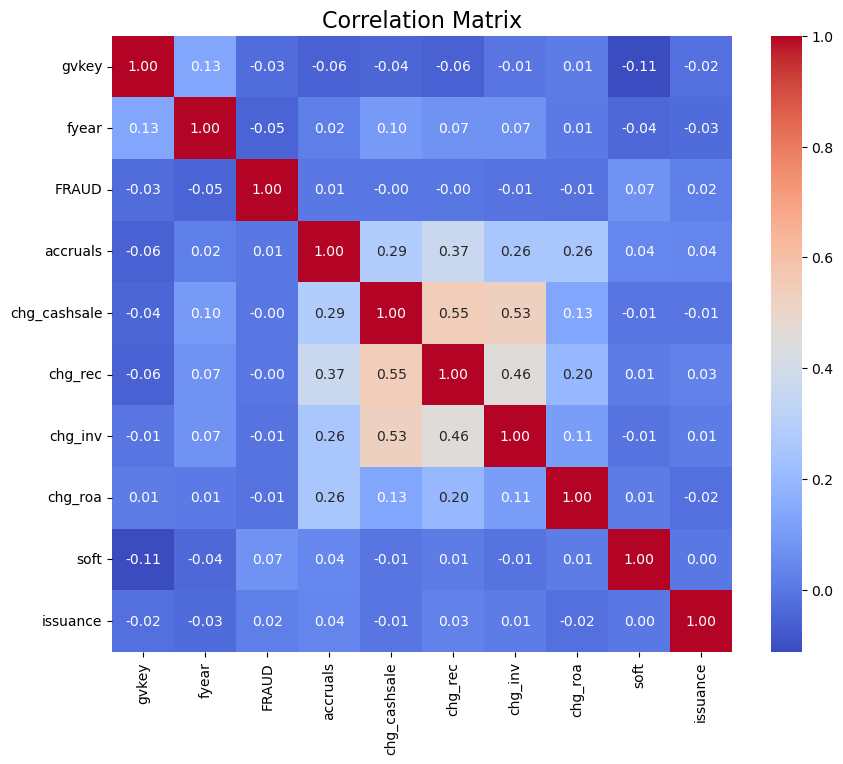

In [8]:
correlation_matrix = fraud_full_sample.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix', fontsize=16)
plt.show()

The code computes the correlation matrix for the variables in the 'fraud_full_sample' dataset and creates a heatmap plot to visualize the correlations. The heatmap provides a quick and easy way to understand the relationships between pairs of variables. Warmer colors represent positive correlations, while cooler colors represent negative correlations. The plot helps to identify patterns and dependencies among the variables, providing insights into their associations.

The output shows that soft assets (intangibles) are This output shows that soft assets (intangibles) are affected by fraud the most and there is no effect for the change in cash sales and change in accounts receivable for fraud.

3. Logistic Regressions (10%)
Use the full sample to estimate the logistic regression
Discuss the results from the regression
Evaluate the performance of the predictions
Try different models (i.e., variables) and parameters (i.e. cut-off points) to find the best model

In [9]:
formula = 'FRAUD ~ accruals + chg_cashsale + chg_rec + chg_inv + chg_roa + soft + issuance'
model = smf.logit(formula, data = fraud_full_sample)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.098087
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  FRAUD   No. Observations:                10213
Model:                          Logit   Df Residuals:                    10205
Method:                           MLE   Df Model:                            7
Date:                Wed, 31 May 2023   Pseudo R-squ.:                 0.03220
Time:                        00:17:17   Log-Likelihood:                -1001.8
converged:                       True   LL-Null:                       -1035.1
Covariance Type:            nonrobust   LLR p-value:                 6.939e-12
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.4393      0.292    -18.654      0.000      -6.011      -4.868
accruals         0.0698

Current function value: 0.098087: This is the value of the log-likelihood function at the estimated parameter values. It represents the goodness of fit of the model to the data, with lower values indicating a better fit.
.
Dep. Variable: FRAUD: This specifies the dependent variable in the model, which is 'FRAUD'.

No. Observations: 10213: This is the total number of observations used in the model.

Model: Logit: Indicates that the model is a logistic regression model.

Df Residuals: 10205: This represents the degrees of freedom for the residuals, which is the difference between the number of observations and the number of estimated parameters.

Method: MLE (Maximum Likelihood Estimation): This indicates that the model was estimated using the maximum likelihood estimation method.

Pseudo R-squ.: 0.03220: This is a measure of the model's goodness of fit, with higher values indicating better fit. In this case, the model explains approximately 3.22% of the variation in the dependent variable.

Coefficients: This table provides the estimated coefficients (coeff) for each predictor variable, along with their standard errors (std err), z-scores (z), and p-values (P>|z|). The coefficients represent the effect of each predictor variable on the log-odds of the dependent variable.

[0.025 0.975]: These values represent the 95% confidence interval for the estimated coefficients.

Interpretation of Coefficients: The coefficients provide information on the direction and magnitude of the relationship between each predictor variable and the log-odds of the dependent variable. Positive coefficients indicate a positive relationship, while negative coefficients indicate a negative relationship. The p-values indicate the statistical significance of each coefficient.

Converged: True: This indicates that the model has converged and reached a stable solution.

The result shows that the variable 'soft' is the only one that has significant coeffcients (p-value < 0.05). Their signs are consistent with the expecation: Firms with more soft assets (intangibles) are more likely to manipulate accounting numbers. However, other variables' coefficients are not statistically different from 0.

In [10]:
matrix = result.pred_table(threshold=0.006)

# Calculate performance statistics
true_p = matrix[1, 1]  # True positive
true_n = matrix[0, 0]  # True negative
false_p = matrix[0, 1]  # False positive
false_n = matrix[1, 0]  # False negative

accuracy = (true_p + true_n) / matrix.sum()
sensitivity = true_p / (true_p + false_n)
specificity = true_n / (true_n + false_p)

print(f'accuracy = {accuracy:.3f}')
print(f'sensitivity = {sensitivity:.3f}')
print('specificity =', round(specificity, 3))

accuracy = 0.055
sensitivity = 0.995
specificity = 0.035


The overall accuracy is 0.055, or 5.5% of total predictions are correct. This is mainly driven by the prediction of no-fraud cases: 3.5% of no-fraud cases have been predicted correctly. But sensitivity is 0.995, or 99.5% of actual fraud cases have been predicted correctly.

In [11]:
import statsmodels.formula.api as smf
import numpy as np
import itertools

# Define the list of potential predictor variables
variables = ['accruals', 'chg_cashsale', 'chg_rec', 'chg_inv', 'chg_roa', 'soft', 'issuance']

# Initialize the best score and best model
best_score = -np.inf
best_model = None
best_formula = None
best_threshold = None

# Test all combinations of predictor variables (this could take a while)
for L in range(1, len(variables) + 1):
    for subset in itertools.combinations(variables, L):
        formula = 'FRAUD ~ ' + ' + '.join(subset)
        
        model = smf.logit(formula, data=fraud_full_sample)
        result = model.fit(disp=False)  # disp=False suppresses convergence messages
        
        # Test different cut-off points
        for threshold in np.linspace(0, 1, 21):  # 21 thresholds between 0 and 1
            matrix = result.pred_table(threshold=threshold)

            true_p = matrix[1, 1]  # True positive
            true_n = matrix[0, 0]  # True negative
            false_p = matrix[0, 1]  # False positive
            false_n = matrix[1, 0]  # False negative

            accuracy = (true_p + true_n) / matrix.sum()

            if accuracy > best_score:
                best_score = accuracy
                best_model = result
                best_formula = formula
                best_threshold = threshold

# Print the results of the best model
print('Best Model:', best_formula)
print('Best Threshold:', best_threshold)
print('Best Score:', best_score)
print(best_model.summary())


Best Model: FRAUD ~ accruals
Best Threshold: 0.05
Best Score: 0.9791442279447763
                           Logit Regression Results                           
Dep. Variable:                  FRAUD   No. Observations:                10213
Model:                          Logit   Df Residuals:                    10211
Method:                           MLE   Df Model:                            1
Date:                Wed, 31 May 2023   Pseudo R-squ.:               0.0001419
Time:                        00:17:23   Log-Likelihood:                -1035.0
converged:                       True   LL-Null:                       -1035.1
Covariance Type:            nonrobust   LLR p-value:                    0.5878
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8435      0.070    -55.022      0.000      -3.980      -3.707
accruals       0.0460      0.086      0.532      0

Define the list of potential predictor variables: The code initializes a list called 'variables' which contains the names of the predictor variables, such as 'accruals', 'chg_cashsale', 'chg_rec', etc.

Initialize the best score and best model: The code sets initial values for the best score, best model, best formula, and best threshold. These variables will be updated during the feature selection process.

Test all combinations of predictor variables: The code uses nested loops to iterate over different combinations of predictor variables. It starts with single-variable models and gradually includes more variables in each iteration. For each combination, it constructs a formula string in the form of 'FRAUD ~ var1 + var2 + ...' using the 'join' function.

Fit logistic regression models: The code uses the 'smf.logit' function from the 'statsmodels' library to fit a logistic regression model based on the formula and the dataset 'fraud_full_sample'. It suppresses convergence messages by setting 'disp=False'.

Test different cut-off points: For each fitted model, the code iterates over a range of threshold values from 0 to 1. It calculates the confusion matrix using the 'pred_table' method from the fitted model and extracts true positives, true negatives, false positives, and false negatives.

Compute accuracy and update the best model: The code calculates the accuracy by dividing the sum of true positives and true negatives by the total number of instances in the confusion matrix. If the accuracy is higher than the current best score, it updates the best score, best model, best formula, and best threshold.

The process continues until all combinations of variables are tested.

Best Model: The logistic regression model with accruals as the independent variable is considered the best model based on the analysis.

Best Threshold: The best threshold value for classification is determined to be 0.05. This threshold is used to classify observations as fraud or non-fraud based on the predicted probabilities from the logistic regression model.

Best Score: The best score achieved by the model is 0.9791442279447763. This score represents the accuracy or performance of the model in predicting fraud.

Logit Regression Results: This section provides the results of the logistic regression analysis. It includes information such as the coefficients (coef) and standard errors (std err) for the intercept and the accruals variable. The coefficient estimates indicate the impact of the variables on the log-odds of the dependent variable. The p-values (P>|z|) associated with the coefficients are used to assess the statistical significance of the variables.

Pseudo R-squared: The pseudo R-squared value of 0.0001419 indicates the proportion of variance in the dependent variable that is explained by the model.

Overall, the logistic regression model suggests that the accruals variable does not have a statistically significant impact on predicting fraud, as its coefficient has a high p-value (0.594). Further analysis and interpretation of the model results would be necessary to gain a deeper understanding of the relationship between the variables and fraud prediction.

4. Machine Learning Methods (12%)

Construct decision trees to predict fraud
Evaluate the predictive performance of the trees and find the best-performing tree
Use K-nearest neighbours to predict fraud
Evaluate the predictive performance and find the best set of variables and parameters (e.g. K) with the maximum accuracy

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# Standardize the variables
x = fraud_full_sample[['accruals', 'chg_cashsale', 'chg_rec', 'chg_inv', 'chg_roa', 'soft', 'issuance']]
X = preprocessing.StandardScaler().fit(x).transform(x)

# Split the data into train and test datasets
y = fraud_full_sample['FRAUD'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Build the Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=10)

# Fit the model to the training data
tree.fit(X_train, y_train)

# Compute and display accuracy score on the test set
score = tree.score(X_test, y_test)
print(f"Decision Tree prediction accuracy = {score:.1%}")

Decision Tree prediction accuracy = 97.6%


Import the necessary libraries: The required libraries for decision tree classification, data splitting, metrics evaluation, and preprocessing are imported.

Standardize the variables: The features (accruals, chg_cashsale, chg_rec, chg_inv, chg_roa, soft, issuance) are extracted from the fraud_full_sample dataset. The features are then standardized using the StandardScaler from the preprocessing module. Standardization scales the features to have zero mean and unit variance, which can be beneficial for certain machine learning algorithms.

Split the data: The standardized features (X) and the target variable (y, which represents fraud) are split into training and testing datasets using the train_test_split function. The test dataset size is set to 20% of the total data, and a random state is used for reproducibility.

Build the Decision Tree: A decision tree classifier is created with specific parameters. The criterion is set to 'entropy', which measures the quality of a split based on the information gain. The max_depth limits the depth of the decision tree to 3 levels. The random_state ensures consistent results across runs.

Fit the model: The decision tree model is trained on the training data (X_train and y_train) using the fit method.

Compute accuracy score: The accuracy of the decision tree model is computed on the test data (X_test and y_test) using the score method. The accuracy represents the proportion of correctly predicted fraud cases out of all cases.

Print the accuracy score: The accuracy score is printed, formatted as a percentage, to evaluate the performance of the decision tree model in predicting fraud.

The accuracy score is the proportion of predictions(classifications) that are correct. The result shows that 97.6% of predictions made by the decision tree is correct.

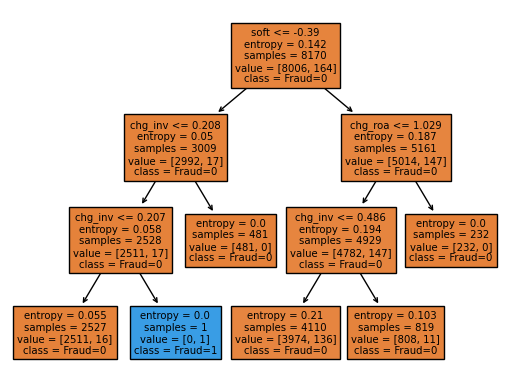

In [13]:
# Visualize the decision tree
from sklearn.tree import plot_tree

features = x.columns[:]
target = ['Fraud=0', 'Fraud=1']
plot_tree(tree, feature_names=features, class_names=target, filled=True)
plt.show()

The features variable is assigned the column names of the input features (x.columns). This will be used to label the different features in the decision tree visualization.

The target variable is defined as a list with two elements: 'Fraud=0' and 'Fraud=1'. This specifies the class names for the target variable in the decision tree visualization.

The plot_tree function is then called, passing in the trained tree model as the first argument. Additionally, feature_names is set to features to label the tree nodes with the corresponding feature names. The class_names parameter is set to target to label the different classes in the tree. The filled parameter is set to True, which colors the nodes in the tree based on the majority class.

Finally, plt.show() is called to display the decision tree visualization using matplotlib.pyplot.

In [14]:
from sklearn.metrics import classification_report

# Evaluate the predictive performance of the decision tree
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))

# Display feature importance
cols = x.columns

for name, val in zip(cols, tree.feature_importances_):
    print(f'{name} importance = {val:.2%}')


              precision    recall  f1-score   support

    No Fraud       0.98      1.00      0.99      1994
       Fraud       0.00      0.00      0.00        49

    accuracy                           0.98      2043
   macro avg       0.49      0.50      0.49      2043
weighted avg       0.95      0.98      0.96      2043

accruals importance = 0.00%
chg_cashsale importance = 0.00%
chg_rec importance = 0.00%
chg_inv importance = 26.60%
chg_roa importance = 13.52%
soft importance = 59.88%
issuance importance = 0.00%


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The classification_report function from the sklearn.metrics module is used to generate a classification report. The predicted labels for the test set are obtained by calling tree.predict(X_test), where tree is the trained decision tree model. The classification_report function takes the true labels (y_test) and the predicted labels (y_pred) as arguments. Additionally, the target_names parameter is set to ['No Fraud', 'Fraud'] to assign labels to the two classes. The classification report provides metrics such as precision, recall, F1-score, and support for each class, as well as the overall accuracy of the model.

Following the classification report, the code displays the feature importance. The column names of the input features are assigned to the cols variable (x.columns). The feature importance is accessed through the feature_importances_ attribute of the decision tree model. The zip function is used to iterate over the cols and tree.feature_importances_ simultaneously. For each feature, the code prints the feature name and its importance as a percentage using f-string formatting.

The output shows the evaluation results of a model that predicts fraud. The model achieved high precision for the "No Fraud" class, indicating a high proportion of correct predictions for non-fraudulent instances. However, it failed to predict any instances of fraud, resulting in low precision, recall, and F1-score for the "Fraud" class. The overall accuracy of the model was 98%.

The feature importance analysis revealed that the "soft" feature had the highest importance in making predictions, followed by "chg_roa" and "chg_inv". On the other hand, the "accruals", "chg_cashsale", and "chg_rec" features had minimal importance in the model's predictions, and the "issuance" feature had no importance.

In summary, the model showed good performance in identifying non-fraudulent instances but struggled to identify fraud. The "soft" feature was the most influential in making predictions, while other features had limited impact.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid for KNN
param_grid_knn = {'n_neighbors': list(range(1, 11))}

# Initialize a GridSearchCV object for KNN
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
    
# Fit grid_search to the data
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy on the training set
print(f"Best KNN parameters: {grid_search_knn.best_params_}")
print(f"Best KNN score on training set: {grid_search_knn.best_score_}")

# Compute and display accuracy score on the test set
score = grid_search_knn.score(X_test, y_test)
print(f"KNN test accuracy with best parameters = {score:.1%}")


Best KNN parameters: {'n_neighbors': 4}
Best KNN score on training set: 0.9799265605875153
KNN test accuracy with best parameters = 97.6%


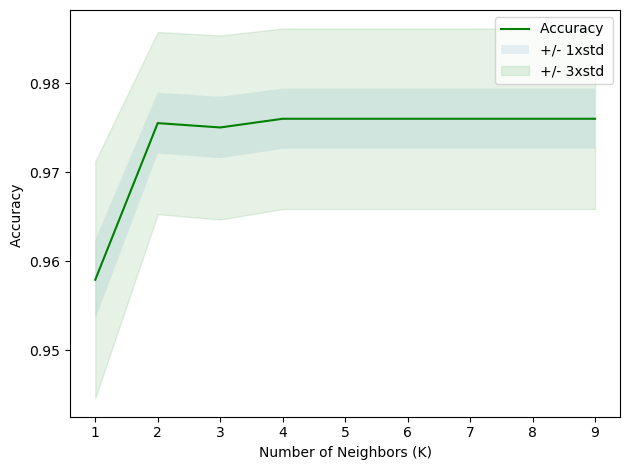

The best accuracy is 0.9760156632403328 with k= 4.


In [16]:
# Try K from 1 to 10
mean_acc = np.zeros(9)
std_acc = np.zeros(9)

for n in range(1, 10):
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,10),mean_acc,'g')
plt.fill_between(range(1,10), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,10), mean_acc - 3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print(f"The best accuracy is {str(mean_acc.max())} with k= {mean_acc.argmax()+1}.")




Initialization:

mean_acc and std_acc are arrays of zeros with length 9. These arrays will store the mean and standard deviation of the accuracy scores for different values of K.

Loop over K values:
    
The loop iterates from 1 to 9, representing the values of K from 1 to 10 (exclusive).
For each iteration, a KNN classifier is created with the current value of K.
The classifier is trained on the training data (X_train and y_train).
The trained classifier predicts the labels for the test data (X_test), and the predicted labels are stored in yhat.
The accuracy of the predictions is calculated using metrics.accuracy_score and stored in mean_acc at the corresponding index.

Plotting:

A line plot is created using plt.plot to visualize the relationship between K values and mean accuracy scores (mean_acc).
The fill_between function is used to create shaded regions around the mean accuracy line, representing the standard deviation.
A legend is added to the plot to label the different elements.
Axes labels (ylabel and xlabel) and plot layout adjustments are made.

The output indicates that the best accuracy achieved using the K-Nearest Neighbors (KNN) algorithm is 0.9760156632403328. This accuracy score is obtained when using a value of K equal to 4.

In [17]:
# Split the data into train and test datasets
y = fraud_full_sample['FRAUD'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define parameter grid for the decision tree
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 3, 4],
    'criterion': ['gini', 'entropy'],
}

# Initialize a GridSearchCV object that will find the best combination of parameters
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=10), param_grid, cv=5, scoring='accuracy')

# Fit grid_search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy on the training set
print(f"Best Decision Tree parameters: {grid_search.best_params_}")
print(f"Best Decision Tree score on training set: {grid_search.best_score_}")

# Compute and display accuracy score on the test set
score = grid_search.score(X_test, y_test)
print(f"Decision Tree test accuracy with best parameters = {score:.1%}")

Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Best Decision Tree score on training set: 0.9798041615667075
Decision Tree test accuracy with best parameters = 97.6%


Split the data into train and test datasets:

The target variable FRAUD is extracted from the fraud_full_sample dataframe and assigned to y.
The features are stored in X.
train_test_split is used to split the data into training and test sets, with a test size of 20% and a random state of 10. The resulting datasets are assigned to X_train, X_test, y_train, and y_test.
Define the parameter grid for the decision tree:

param_grid is a dictionary that specifies the values to be searched for different hyperparameters of the decision tree. It includes max_depth (maximum depth of the tree), min_samples_split (minimum number of samples required to split an internal node), and criterion (impurity criterion used for splitting).
Initialize a GridSearchCV object:

grid_search is created with the DecisionTreeClassifier as the estimator, the parameter grid, 5-fold cross-validation, and the accuracy scoring metric.
Fit the grid search to the data:

grid_search.fit(X_train, y_train) performs the grid search using the training data. It explores different combinations of hyperparameters and evaluates their performance using cross-validation.
Print the best parameters and corresponding training score:

grid_search.best_params_ displays the best combination of parameters found during the grid search.
grid_search.best_score_ shows the accuracy score obtained by the best model on the training set.
Compute and display the accuracy score on the test set:

score = grid_search.score(X_test, y_test) calculates the accuracy score of the best model on the test data.
print(f"Decision Tree test accuracy with best parameters = {score:.1%}") prints the accuracy score as a percentage.

"Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}"

This line shows the best combination of parameters found by the grid search. In this case, the best parameters are:
criterion: 'gini', which indicates that the Gini impurity criterion is used for splitting nodes in the Decision Tree.
max_depth: 3, which represents the maximum depth of the Decision Tree.
min_samples_split: 2, indicating the minimum number of samples required to split an internal node.

"Best Decision Tree score on the training set: 0.9798041615667075"

This line displays the accuracy score obtained by the best Decision Tree model on the training set. The score indicates how well the model fits the training data. In this case, the best model achieved an accuracy of approximately 97.98% on the training set.

"Decision Tree test accuracy with best parameters = 97.6%"

This line shows the accuracy score of the best Decision Tree model on the test set. The score represents how well the model generalizes to unseen data. In this case, the best model achieved an accuracy of approximately 97.6% on the test set.
Overall, the output informs us about the optimal parameter values found through t.